In [1]:
import csv
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
from IPython.display import Image
from shapely.geometry import Point, Polygon
from math import factorial
import datetime
import time
import scipy
import os, os.path

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import Ridge
import random

from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from patsy import cr
from patsy import dmatrix 

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import mean_squared_error
from math import sqrt


import sys
# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')
import remote_sensing_core as rc
import remote_sensing_core as rcp

start = time.time()

# Directories

In [2]:
data_dir = "/Users/hn/Documents/01_research_data/" + \
           "remote_sensing/01_NDVI_TS/no_ID/Grant/No_EVI/Grant_10_cloud/Grant_2017/"

In [3]:
output_dir = data_dir
plot_dir_base = data_dir + "plots/"

# Data reading

In [4]:
file_names = ["Grant_2017_TS.csv"]
file_N = file_names[0]
a_df = pd.read_csv(data_dir + file_N)

# The following columns do not exist in the old data
a_df['CovrCrp'] = "NA" 
a_df['DataSrc'] = "NA" 

a_df = rc.initial_clean_NDVI(a_df)
a_df.head(2)

,Acres,B2,B3,B4,B8,CropGrp,CropTyp,ExctAcr,IntlSrD,Irrigtn,...,Shap_Ar,Shp_Lng,Source,TRS,county,doy,year,geo,CovrCrp,DataSrc
0,36,0.092407,0.070650,0.071444,0.109662,Herb,Mint,35.813572,2003/07/01 00:00:00,Drip,...,144932.383795,1572.482519,WSDA,T16R27E23,Grant,62.0,2017.0,"{""type"":""Polygon"",""coordinates"":[[[-119.404844...",NA,NA
1,36,0.105605,0.107085,0.075052,0.436749,Herb,Mint,35.813572,2003/07/01 00:00:00,Drip,...,144932.383795,1572.482519,WSDA,T16R27E23,Grant,119.0,2017.0,"{""type"":""Polygon"",""coordinates"":[[[-119.404844...",NA,NA


In [5]:
an_EE_TS = a_df.copy()
an_EE_TS = an_EE_TS.iloc[1:1000]

# an_EE_TS = rc.initial_clean_NDVI(an_EE_TS)

### List of unique polygons
polygon_list = an_EE_TS['geo'].unique()
print(len(polygon_list))

output_columns = ['Acres', 'CovrCrp', 'CropGrp', 'CropTyp',
                  'DataSrc', 'ExctAcr', 'IntlSrD', 'Irrigtn', 'LstSrvD', 'Notes',
                  'RtCrpTy', 'Shap_Ar', 'Shp_Lng', 'TRS', 'county', 'year', 'geo',
                  'peak_Doy', 'peak_value']

all_polygons_and_their_peaks = pd.DataFrame(data=None, 
                                            index=np.arange(3*len(an_EE_TS)), 
                                            columns=output_columns)

double_columns = ['Acres', 'CovrCrp', 'CropGrp', 'CropTyp',
                  'DataSrc', 'ExctAcr', 'IntlSrD', 'Irrigtn', 'LstSrvD', 'Notes',
                  'RtCrpTy', 'Shap_Ar', 'Shp_Lng', 'TRS', 'county', 'year', 'geo']

double_polygons = pd.DataFrame(data=None, 
                               index=np.arange(2*len(an_EE_TS)), 
                               columns=double_columns)

32


In [6]:
a_poly = polygon_list[0]
curr_field = an_EE_TS[an_EE_TS['geo']==a_poly]

year = int(curr_field['year'].unique())
plant = curr_field['CropTyp'].unique()[0]

plant = plant.replace("/", "_")
plant = plant.replace(",", "_")
plant = plant.replace(" ", "_")

county = curr_field['county'].unique()[0]
TRS = curr_field['TRS'].unique()[0]

### 
###  There is a chance that a polygon is repeated twice?
###

X = curr_field['doy']
y = curr_field['NDVI']
freedom_df = 10

In [7]:
#############################################
###
###             Smooth Spline
###
#############################################

# Generate spline basis with "freedom_df" degrees of freedom
x_basis_spline = cr(X, df=freedom_df, constraints='center')

# Fit model to the data
spline_model = LinearRegression().fit(x_basis_spline, y)

# Get estimates
y_predic_spline = spline_model.predict(x_basis_spline)

In [8]:
peaks_spline = rc.peakdetect(y_predic_spline, lookahead=5, delta=0);
max_peaks =  peaks_spline[0];
peaks_spline = rc.form_xs_ys_from_peakdetect(max_peak_list = max_peaks, doy_vect=X);
# print(peaks_spline)
DoYs_series = pd.Series(peaks_spline[0]);
peaks_series = pd.Series(peaks_spline[1]);

"""
peaks_spline_const = rc.peakdetect(y_const_pred_spline, lookahead = 10, delta=0)
max_peaks_const =  peaks_spline_const[0]
peaks_spline_const = rc.form_xs_ys_from_peakdetect(max_peak_list = max_peaks_const, doy_vect=X_const)
# print(peaks_spline)
DoYs_series_const = pd.Series(peaks_spline_const[0])
peaks_series_const = pd.Series(peaks_spline_const[1])
"""

'\npeaks_spline_const = rc.peakdetect(y_const_pred_spline, lookahead = 10, delta=0)\nmax_peaks_const =  peaks_spline_const[0]\npeaks_spline_const = rc.form_xs_ys_from_peakdetect(max_peak_list = max_peaks_const, doy_vect=X_const)\n# print(peaks_spline)\nDoYs_series_const = pd.Series(peaks_spline_const[0])\npeaks_series_const = pd.Series(peaks_spline_const[1])\n'

# Natural Cubic Spline

In [9]:
train_y = y
# Generating natural cubic spline
transformed_x3 = dmatrix("cr(train, df = 10)", {"train": X}, return_type='dataframe')

NCS_fit = sm.GLM(train_y, transformed_x3).fit()
#
# Prediction on validation set
#
y_NCS_pred = NCS_fit.predict(dmatrix("cr(valid, df=10)", {"valid": X}, return_type='dataframe'))

#
# Calculating RMSE value
#
# rms = sqrt(mean_squared_error(train_y, y_NCS_pred))
# print(rms)

In [10]:
NCS_peakse = rc.my_peakdetect(y_axis=y_NCS_pred, x_axis=X, delta=0.1);
NCS_max_peaks =  NCS_peakse[0];
NCS_peaks_spline = rc.separate_x_and_y(max_peak_list = NCS_max_peaks);
# print(peaks_spline)
NCS_DoYs_series = pd.Series(NCS_peaks_spline[0]);
NCS_peaks_series = pd.Series(NCS_peaks_spline[1]);

In [ ]:
sb.set_style("dark")
fig, ax = plt.subplots(figsize=(8,6));


plot_title = county + ", " + plant + ", " + str(year) + " (" + TRS + ")"


# ax.plot(X, y, label="NDVI data");
ax.scatter(X, y, s=10, c='b', marker='o', label="NDVI data");
########################################################
#
#              smoothing spline 
#
########################################################
ax.plot(X, y_predic_spline, 'r', label="spline") # Line
ax.scatter(DoYs_series, peaks_series, s=100, c='r', marker='*'); # Peaks

########################################################
#
#             natural smoothing spline 
#
########################################################
ax.plot(X, y_NCS_pred, 'g-.', label="natural spline") # Line
ax.scatter(NCS_DoYs_series, NCS_peaks_series, s=100, c='g', marker='*'); # Peaks

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='NDVI')
ax.legend(loc="best");

########################################################
#
#     Save the figure
#
########################################################
fig_name = "/Users/hn/Desktop/" + 'splie_vs_naturalSpline.png'
plt.savefig(fname = fig_name, \
            dpi=300, 
            bbox_inches='tight')

# constant vector size

In [ ]:
#############################################
###
###          Constant vector size
###
#############################################
X_const = np.arange(start=1, stop=365, step=14)


#############################################
###
###          Spline
###
#############################################
x_const_basis_spline = cr(X_const, df=(freedom_df), constraints='center')
x_const_basis = pd.DataFrame(x_const_basis_spline)
y_const_pred_spline = spline_model.predict(x_const_basis_spline)

#############################################
###
###          Natural Spline
###
#############################################

first_arg = "cr(X_const, df=" + str(freedom_df) + ")"
y_const_pred_NCS = NCS_fit.predict(dmatrix(first_arg, {"X_const": X_const}, return_type='dataframe'))
len(y_const_pred_NCS)

In [ ]:
sb.set_style("dark")
fig, ax = plt.subplots(figsize=(8,6));


plot_title = county + ", " + plant + ", " + str(year) + " (" + TRS + ")"


# ax.plot(X, y, label="NDVI data");
ax.scatter(X, y, s=10, c='b', marker='o', label="NDVI data");
########################################################
#
#              smoothing spline 
#
########################################################
ax.plot(X, y_predic_spline, 'r', label="spline") # Line

########################################################
#
#             natural smoothing spline 
#
########################################################
ax.plot(X, y_NCS_pred, 'g-.', label="natural spline") # Line


########################################################
#
#              a-year-long smoothing spline 
#
########################################################
ax.plot(X_const, y_const_pred_spline, 'k', label="year-long spline") # Line

########################################################
#
#              a-year-long Natural spline 
#
########################################################
ax.plot(X_const, y_const_pred_NCS, 'c-.', label="year-long Natural spline") # Line



ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='NDVI')
ax.legend(loc="best");


In [ ]:
pointer = 0
double_pointer = 0
counter = 0

for a_poly in polygon_list:
    if (counter%1000 == 0):
        print (counter)
    counter += 1
    curr_field = an_EE_TS[an_EE_TS['geo']==a_poly]

    year = int(curr_field['year'].unique())
    plant = curr_field['CropTyp'].unique()[0]
    
    plant = plant.replace("/", "_")
    plant = plant.replace(",", "_")
    plant = plant.replace(" ", "_")
    
    county = curr_field['county'].unique()[0]
    TRS = curr_field['TRS'].unique()[0]

    ### 
    ###  There is a chance that a polygon is repeated twice?
    ###

    X = curr_field['doy']
    y = curr_field['NDVI']
    freedom_df = 10
    #############################################
    ###
    ###             Smoothen
    ###
    #############################################

    # Generate spline basis with "freedom_df" degrees of freedom
    x_basis = cr(X, df=freedom_df, constraints='center')

    # Fit model to the data
    model = LinearRegression().fit(x_basis, y)

    # Get estimates
    y_predic = model.predict(x_basis)


    #############################################
    ###
    ###             find peaks
    ###
    #############################################
    # peaks_LWLS_1 = peakdetect(LWLS_1[:, 1], lookahead = 10, delta=0)
    # max_peaks = peaks_LWLS_1[0]
    # peaks_LWLS_1 = form_xs_ys_from_peakdetect(max_peak_list = max_peaks, doy_vect=X)

    peaks_spline = rc.peakdetect(y_predic, lookahead = 10, delta=0)
    max_peaks =  peaks_spline[0]
    peaks_spline = rc.form_xs_ys_from_peakdetect(max_peak_list = max_peaks, doy_vect=X)
    # print(peaks_spline)
    DoYs_series = pd.Series(peaks_spline[0])
    peaks_series = pd.Series(peaks_spline[1])

    peak_df = pd.DataFrame({ 
                       'peak_Doy': DoYs_series,
                       'peak_value': peaks_series
                      }) 


    WSDA_df = rc.keep_WSDA_columns(curr_field)
    WSDA_df = WSDA_df.drop_duplicates()
    
    if (len(peak_df)>0):
        WSDA_df = pd.concat([WSDA_df]*peak_df.shape[0]).reset_index()
        # WSDA_df = pd.concat([WSDA_df, peak_df], axis=1, ignore_index=True)
        WSDA_df = WSDA_df.join(peak_df)
        if ("index" in WSDA_df.columns):
            WSDA_df = WSDA_df.drop(columns=['index'])

        # all_polygons_and_their_peaks = all_polygons_and_their_peaks.append(WSDA_df, sort=False)

        """
        copy the .values. Otherwise the index inconsistency between
        WSDA_df and all_poly... will prevent the copying.
        """
        all_polygons_and_their_peaks.iloc[pointer:(pointer + len(WSDA_df))] = WSDA_df.values
        #
        #  if we have double peaks add them to the double_polygons
        #
        if (len(WSDA_df) == 2):
            print(plant, county, year, counter)
            WSDA_df = WSDA_df.drop(columns=['peak_Doy', 'peak_value'])
            WSDA_df = WSDA_df.drop_duplicates()
            double_polygons.iloc[double_pointer:(double_pointer + len(WSDA_df))] = WSDA_df.values
            double_pointer += len(WSDA_df)

        pointer += len(WSDA_df)
        
        #############################################
        ###
        ###             plot
        ###
        #############################################
        sub_out = "/" + plant + "/"
        plot_path = plot_dir_base + sub_out
        os.makedirs(plot_path, exist_ok=True)
        if (len(os.listdir(plot_path))<100):
            plot_title = county + ", " + plant + ", " + str(year) + " (" + TRS + ")"
            sb.set();
            fig, ax = plt.subplots(figsize=(8,6));
            ax.plot(X, y, label="NDVI data");
            ax.plot(X, y_predic, 'r', label="smoothing spline result")
            ax.scatter(DoYs_series, peaks_series, s=100, c='g', marker='*');
            ax.set_title(plot_title);
            ax.set(xlabel='DoY', ylabel='NDVI')
            ax.legend(loc="best");

            fig_name = plot_path + county + "_" + plant + "_" + str(year) + "_" + str(counter) + '.png'
            plt.savefig(fname = fig_name, \
                        dpi=500, 
                        bbox_inches='tight')
            del(plot_path, sub_out, county, plant, year)
            plt.close()

        # to make sure the reference by address thing 
        # will not cause any problem.
    del(WSDA_df)

all_polygons_and_their_peaks = all_polygons_and_their_peaks[0:(pointer+1)]
double_polygons = double_polygons[0:(double_pointer+1)]

out_name = output_dir + 'all_polygons_and_their_peaks.csv'
all_polygons_and_their_peaks.to_csv(out_name, index = False)

out_name = output_dir + 'double_polygons.csv'
double_polygons.to_csv(out_name, index = False)

# Polynomial fit to the NDVI data

In [ ]:
polynomial_degree = 6
poly = PolynomialFeatures(degree = polynomial_degree)

x_in = X.values.reshape(-1, 1)
X_poly = poly.fit_transform(x_in)
# print(X_poly.shape)

polynomial_fit = LinearRegression() 
polynomial_fit.fit(X_poly, y)

In [ ]:
plt.scatter(X, y, color = 'blue') 
  
plt.plot(x_in, polynomial_fit.predict(X_poly), color = 'red') 
plt.title('Polynomial Regression') 
plt.xlabel('Temperature') 
plt.ylabel('Pressure') 
  
plt.show() 

# Ridge Regression

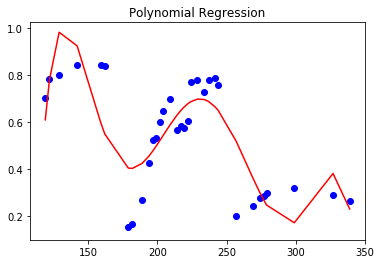

In [47]:
poly = PolynomialFeatures(degree = 6)

x_in = X.values.reshape(-1, 1)
y_in = y.values.reshape(-1, 1)

X_poly = poly.fit_transform(x_in)
ridgereg = Ridge(alpha=0, normalize=True)
ridgereg.fit(X_poly, y_in)
y_pred = ridgereg.predict(X_poly)

plt.scatter(X, y, color = 'blue') 
  
plt.plot(X, y_pred, color = 'red') 
plt.title('Polynomial Regression') 
plt.show() 

(33, 1)

In [ ]:
clf

In [ ]:
#
# Example of Ridge regression 
#
n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
x_4_ridge = rng.randn(n_samples, n_features)

x_4_ridge = np.arange(1,11).reshape(-1, 1)
y_4_ridge = rng.randn(n_samples)

poly = PolynomialFeatures(degree = 4)
X_poly = poly.fit_transform(x_4_ridge)

ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_poly, y_4_ridge)
y_pred = ridgereg.predict(X_poly)

plt.scatter(x_4_ridge, y_4_ridge, color = 'blue') 
  
plt.plot(x_4_ridge, y_pred, color = 'red') 
plt.title('Polynomial Regression') 
plt.show() 

In [ ]:
#
# Example of polynomal regression 
#
import numpy.random as rand
rand.seed(30)
x_test = np.arange(1,10).reshape(-1, 1)
y_test = np.random.rand(9, 1)
poly = PolynomialFeatures(degree = 4)
X_poly = poly.fit_transform(x_test)
lin2 = LinearRegression() 
lin2.fit(X_poly, y_test) 

plt.scatter(x_test, y_test, color = 'blue') 
  
plt.plot(x_test, lin2.predict(X_poly), color = 'red') 
plt.title('Polynomial Regression') 
plt.xlabel('Temperature') 
plt.ylabel('Pressure') 
  
plt.show() 